In [197]:
import os 
import sys 
import cv2 
import matplotlib.pyplot as plt 
from matplotlib.font_manager import FontProperties
import numpy as np 
import pandas as pd 
import scipy.spatial.distance as dist 
from scipy.stats import kurtosis, skew 
from pylab import mpl 
import pymannkendall as mk 
import statsmodels.api as sm 
from fastdtw import fastdtw 
from sklearn.decomposition import PCA 

# set font 
# mpl.rcParams['font.sans-serif'] = ["SimHei"]
# # solve the problem of negative sign display 
# plt.rcParams['axes.unicode_minus'] = False 
# # set the width of the coordinate axis 
# plt.rcParams['axes.linewidth'] = 2

In [198]:
# variables
# get natural data file name 
file_names = os.listdir("../../event_csv/split_data/class2/")
# get artificial data file name 
files = os.listdir('../../event_csv/split_data/artificial/')

# true data of the original data 
nature_real_count = np.load('../npy_file/nature_data_real_count.npy')
# artificial data real count tag 
artificial_real_count = np.load('../npy_file/artificial_data_real_count.npy')

# repnet network's predicitve label on original data 
repnet_nature_pred_count = np.load('../npy_file/repnet_nature_data_real_count.npy')
# repnet network's prediction label on artificial syntheic data 
repnet_artificial_pred_count = np.load('../npy_file/repnet_artificial_data_real_count.npy')


In [199]:
sys.path.append('../') # going a step back so the importer can find the following module
from time_series_scripts import artificial_data_compose 

In [200]:
class_num = 2 
file_name = file_names[0]
print(file_name)
df = pd.read_csv(f'../../event_csv/compress_event_manhattan/class{class_num}/{file_name}')
df.head(), df.shape


user02_fluorescent.csv


(           x          y
 0  41.500000  60.500000
 1  35.000000  81.000000
 2  47.333333  62.333333
 3  37.666667  79.666667
 4  39.400000  62.400000,
 (73688, 2))

In [201]:
# intermediate pca method
from sklearn.decomposition import PCA, IncrementalPCA
data = df.values

In [202]:
ipca = IncrementalPCA(n_components=1, batch_size=1000)
pca = PCA(n_components=1) 

ipca_data = ipca.fit_transform(data)
pca_data = pca.fit_transform(data) 

In [203]:
ipca, pca 

(IncrementalPCA(batch_size=1000, n_components=1), PCA(n_components=1))

In [204]:
ipca_data, pca_data

(array([[ 7.91872868],
        [20.01820179],
        [12.96508973],
        ...,
        [ 4.57644328],
        [12.58111183],
        [ 2.02138456]]),
 array([[ 8.29599714],
        [17.8570497 ],
        [13.76621627],
        ...,
        [ 4.73605812],
        [13.28240734],
        [ 2.47887181]]))

In [205]:
diff_df = pd.DataFrame(ipca_data - pca_data)

In [206]:
diff_df.describe()

,0
count,7.368800e+04
mean,9.522245e-15
std,1.152391e+00
min,-8.538849e+00
25%,-8.502541e-01
50%,-1.378268e-01
75%,7.470126e-01
max,7.489994e+00


In [207]:
pca_df = pd.DataFrame(pca_data)
ipca_df = pd.DataFrame(ipca_data)

<Axes: >

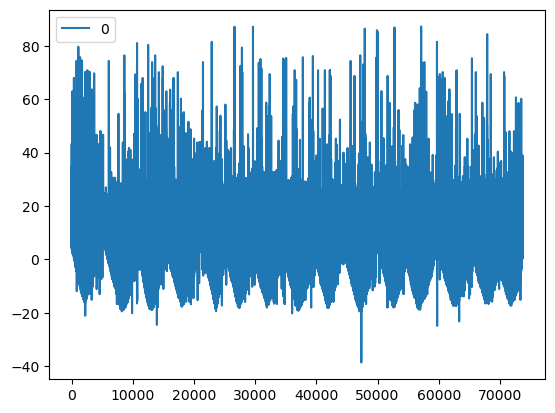

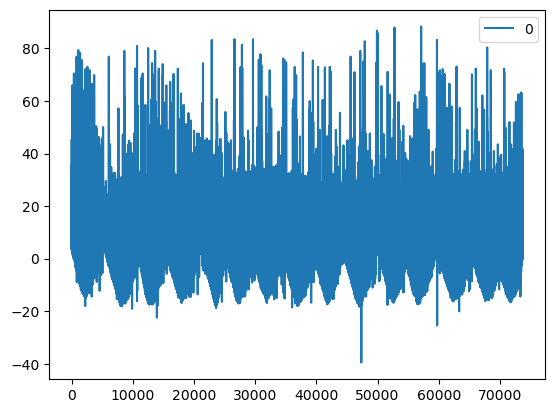

In [208]:
pca_df.plot()
ipca_df.plot()

In [209]:
def load_data_chunk(file_path, chunk_size = 1000):
    for chunk in pd.read_csv(file_path, chunksize=chunk_size):
        yield chunk.values
        
class_num = 2 
file_name = file_names[0]
file_path = f'../../event_csv/compress_event_manhattan/class{class_num}/{file_name}'

n_components = 1 
ipca = IncrementalPCA(n_components= n_components)

chunk_size = 5000 

for data_chunk in load_data_chunk(file_path, chunk_size):
    ipca.partial_fit(data_chunk)

# at this point, IPCA has been fitted incrementally 
# to transform data using the learned componenets 

partial_ipca_df = None
for data_chunk in load_data_chunk(file_path, chunk_size):
    transformed_data = ipca.transform(data_chunk) 
    transformed_data_df = pd.DataFrame(transformed_data)
    if type(partial_ipca_df) == type(None):
        partial_ipca_df = transformed_data_df     
    print(transformed_data_df.shape, partial_ipca_df.shape)
    partial_ipca_df = pd.concat([partial_ipca_df, transformed_data_df])


(5000, 1) (5000, 1)
(5000, 1) (10000, 1)
(5000, 1) (15000, 1)
(5000, 1) (20000, 1)
(5000, 1) (25000, 1)
(5000, 1) (30000, 1)
(5000, 1) (35000, 1)
(5000, 1) (40000, 1)
(5000, 1) (45000, 1)
(5000, 1) (50000, 1)
(5000, 1) (55000, 1)
(5000, 1) (60000, 1)
(5000, 1) (65000, 1)
(5000, 1) (70000, 1)
(3688, 1) (75000, 1)


In [210]:
partial_ipca_df

,0
0,8.087904
1,19.196300
2,13.315664
3,19.955012
4,8.128917
...,...
3683,13.960693
3684,2.784149
3685,4.650779
3686,12.890773


# hp filter test

1. apply hp filter in overlapping chunks

In [211]:
import numpy as np 
from statsmodels.tsa.filters.hp_filter import hpfilter 

def apply_hp_filter_in_chunks(data, chunk_size, overlap_size, lamb = 1600):
    n = len(data)
    filtered_data = [] 
    for i in range(0, n, chunk_size - overlap_size):
        chunk_end = min(i + chunk_size, n) 
        chunk = data[0 : chunk_end]
        if len(chunk) > 1:
            cycle, trend = hpfilter(chunk, lamb)
            if i == 0 : 
                filtered_data.extend(trend[: chunk_size - overlap_size])
            else: 
                filtered_data.extend(trend[overlap_size:chunk_size - overlap_size])
    
    return np.array(filtered_data)

2. applying the exponential moving average 

In [212]:
def exponential_moving_average(data, alpha = 0.1):
    ema = [] 
    ema_current = data[0] 
    ema.append(ema_current) 
    
    for value in data[1:] :
        ema_current = alpha * value + (1 - alpha) * ema_current
        ema.append(ema_current) 
    
    return np.array(ema) 

data = pca_df.values
alpha = 0.05
smoothed_data = exponential_moving_average(data, alpha) 


<Axes: >

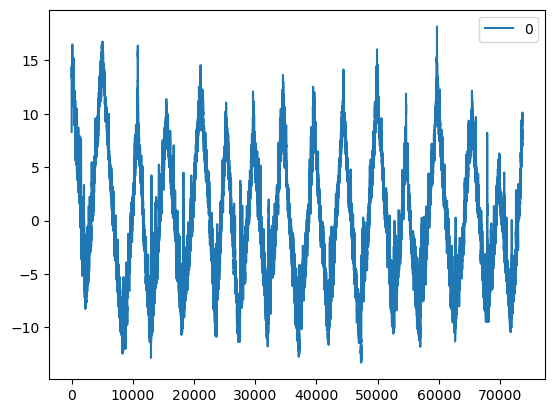

In [213]:
temp_df = pd.DataFrame(smoothed_data) 
temp_df.plot()

3. applying kalman filter 

In [214]:
import numpy as np 
class KalmanFilter:
    def __init__(self, process_variance, measurement_variance, estimation_error, initial_estimate):
        self.process_variance = process_variance            # Q: process noise covariance
        self.measurement_variance = measurement_variance    # R: Measurement noise covariance 
        self.estimation_error = estimation_error            # P: Estimation error covariance 
        self.estimate = initial_estimate                    # x_hat: initial estimate 
        ...
    def update(self, measurement):
        # prediction step 
        prior_estimate = self.estimate 
        prior_error = self.estimation_error + self.process_variance 
        
        # update step (Kalman gain) 
        kalman_gain = prior_error / (prior_error + self.measurement_variance) 
        self.estimate = prior_estimate + kalman_gain * (measurement - prior_estimate) 
        self.estimation_error = (1 - kalman_gain) * prior_error

        return self.estimate

In [215]:
kf = KalmanFilter(process_variance=1e-5, measurement_variance=0.1**2, estimation_error=1, initial_estimate=0) 

# apply the kalman filter to the data 
kf_data = []
for measurement in pca_data:
    kf_data.append(kf.update(measurement))
kf_data = np.array(kf_data)

<Axes: >

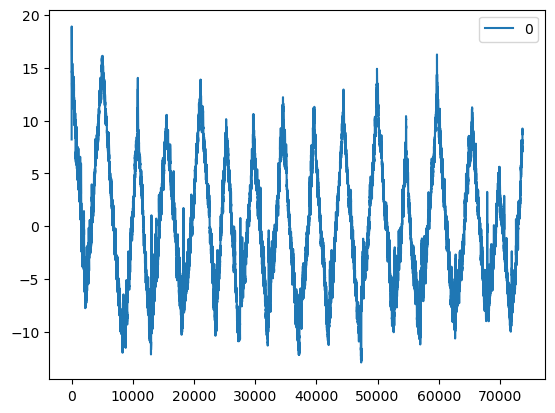

In [216]:
kf_df = pd.DataFrame(kf_data)
kf_df.plot()

In [217]:
ch_sz = 25000
overlap_sz = int(0.2 * ch_sz)
after_pca = apply_hp_filter_in_chunks(pca_df.values, chunk_size=ch_sz, overlap_size=overlap_sz)

In [218]:
after_pca

array([-7.64637567, -7.43229969, -7.21961024, ...,  4.59873157,
        4.71782103,  4.84021564])

In [219]:
after_pca

array([17.20025704, 17.29235183, 17.37888145, ...,  3.62380053,
        3.83989087,  4.04668395])

<Axes: >

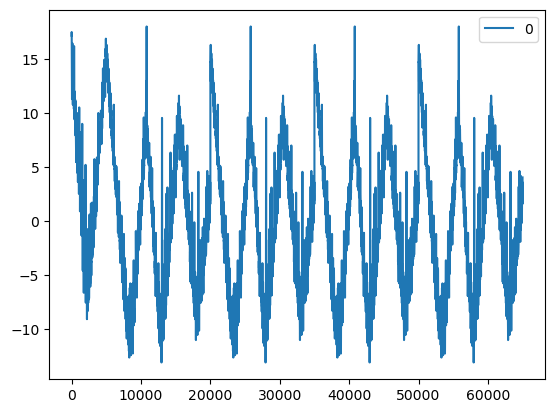

In [220]:
temp_df = pd.DataFrame(after_pca)
temp_df.describe()
temp_df.plot()

<Axes: >

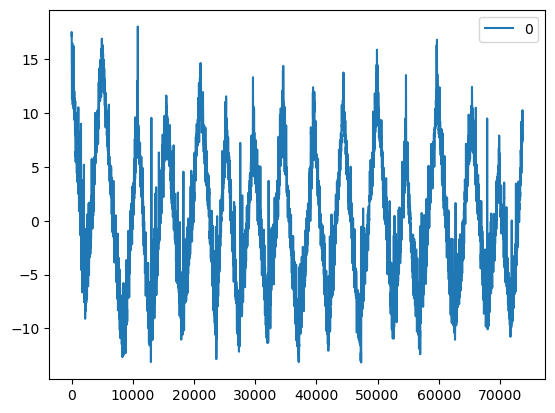

In [165]:
_, smooth = hpfilter(pca_data)
smooth_df = pd.DataFrame(smooth)
smooth_df.plot()